In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re, unicodedata
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split

In [ ]:
combined_data = pd.read_csv('/content/drive/MyDrive/Python_Training/Final_Project/combined_data.csv')
combined_data

,id,report,memc,bypass,csrf,dirtra,dos,execution,fileinc,gainpre,httprs,infor,overflow,sqli,xss
0,CVE-1999-0001,ip_input.c in BSD-derived TCP/IP implementatio...,0,0,0,0,1,0,0,0,0,0,0,0,0
1,CVE-1999-0002,Buffer overflow in NFS mountd gives root acces...,0,0,0,0,0,0,0,0,0,0,1,0,0
2,CVE-1999-0003,Execute commands as root via buffer overflow i...,0,0,0,0,0,0,0,0,0,0,1,0,0
3,CVE-1999-0004,"MIME buffer overflow in email clients, e.g. So...",0,0,0,0,0,0,0,0,0,0,1,0,0
4,CVE-1999-0005,Arbitrary command execution via IMAP buffer ov...,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115820,CVE-2021-43141,Cross Site Scripting (XSS) vulnerability exist...,0,0,0,0,0,0,0,0,0,0,0,0,1
115821,CVE-2021-43264,"In Mahara before 20.04.5, 20.10.3, 21.04.2, an...",0,1,0,1,0,0,0,0,0,0,0,0,0
115822,CVE-2021-43265,"In Mahara before 20.04.5, 20.10.3, 21.04.2, an...",0,0,0,0,0,0,0,0,0,0,0,0,1
115823,CVE-2021-43266,"In Mahara before 20.04.5, 20.10.3, 21.04.2, an...",0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
word_vector = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Python_Training/Final_Project/vulner_embedding.bin", binary=True)
name_labels = ['memcached', 'bypass', 'cross site request forgery', 'directory traversal', 'denial service', 'execution', 'file inclusion', 'gain privilege',
          'http response splitting', 'information disclosure', 'overflow', 'sql injection', 'cross site scripting']
csv_labels = ['memc', 'bypass',	'csrf',	'dirtra',	'dos', 'execution',	'fileinc',	'gainpre',	'httprs',	'infor',	'overflow',	'sqli',	'xss']

##extract_data

In [ ]:
def process_bar(idx, num):
    per = idx / num * 100
    if per % 10 == 0:
        print(f'Processing {int(per)}%')


def process_report(report):
    report = report.lower()
    report = re.sub("<!--?.*?-->", "", report)
    report = unicodedata.normalize('NFKD', report).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    report= re.sub("(\\d|\\W)+"," ",report)
    report = re.sub('[^a-zA-z0-9\s]', "", report)
    sentences = [sentence for sentence in report.split() if sentence in word_vector]
    return sentences


def similar_counter(label, sentences):
  count = 0
  for sentence in sentences:
    similarity = word_vector.similarity(label, sentence)
    if similarity > 0.65:
      count += 1
  return count

In [ ]:
def similarities_extractor(report):
  sentences = process_report(report)
  similar_vectors = []
  for label in name_labels:
    label_parts = [label_part for label_part in label.split()]
    counter = 0
    for label_part in label_parts:
      counter += similar_counter(label_part, sentences)
    similar_vectors.append(counter)
  return similar_vectors


def feautures_extractor(report):
  sentences = process_report(report)
  vectors = [word_vector[sentence] for sentence in sentences]
  avg_vectors = np.mean(vectors, axis=0)
  return avg_vectors


def extract_data(df, labels):
  avg_vectors = []
  similar_vectors = []
  for idx in range(df.shape[0]):
    process_bar(idx, df.shape[0])
    if idx == df.shape[0] - 1:
      print(f'Processing 100%')
    avg_vector = feautures_extractor(df['report'][idx])
    similar_vector = similarities_extractor(df['report'][idx])
    avg_vectors.append(avg_vector)
    similar_vectors.append(similar_vector)

  features_df = pd.DataFrame(avg_vectors)
  similarities_df = pd.DataFrame(similar_vectors)
  X = pd.concat([similarities_df, features_df], axis=1)
  X = X.astype(float)
  y = df[labels].values
  y = pd.DataFrame(y)
  return X, y

In [ ]:
X, y = extract_data(combined_data, csv_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_train = y_train.apply(lambda x: x.argmax(), axis=1).values
y_test = y_test.apply(lambda x: x.argmax(), axis=1).values
X_train

Processing 0%
Processing 20%
Processing 40%
Processing 60%
Processing 80%
Processing 100%


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
80393,0.0,0.0,4.0,1.0,0.0,1.0,3.0,2.0,0.0,0.0,...,0.005545,0.256038,-0.035194,-0.205916,-0.043632,-0.109978,-0.186676,0.115486,0.324920,0.209536
75434,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.008237,0.192773,0.027603,-0.045702,-0.125776,-0.014398,-0.154694,0.186873,0.314899,0.170236
33660,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.064956,0.190549,-0.073223,-0.143523,-0.148786,-0.149988,-0.183933,0.171575,0.251542,0.109643
5354,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.002200,0.288565,0.139854,-0.194079,-0.099517,-0.112046,-0.104670,0.187060,0.146270,0.139633
38234,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.175148,0.259937,-0.077651,-0.024399,-0.013450,-0.065702,-0.197802,0.088434,0.263763,0.139431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87500,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,...,0.121584,0.260916,-0.071609,-0.206955,0.008843,-0.056005,-0.146066,0.140008,0.205278,0.131301
100278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.070857,0.229340,-0.103033,-0.066749,0.022167,-0.087752,-0.226795,0.123944,0.265781,0.186967
19914,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.065513,0.230525,-0.043930,-0.147296,-0.150247,-0.070265,-0.166834,0.128568,0.364632,0.207883
38604,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.078515,0.267492,0.000613,-0.149058,-0.096618,-0.109553,-0.190230,0.121402,0.247853,0.258336


##model & prediction

In [ ]:
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

gnb = GaussianNB().fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)

accuracy = gnb.score(X_test, y_test)
precision = precision_score(y_test, gnb_predictions, average='macro')
recall = recall_score(y_test, gnb_predictions, average='macro')
f1score = f1_score(y_test, gnb_predictions, average='macro')
print(f'Accuracy: {accuracy:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1 Score: {f1score:.4f}')

Accuracy: 0.7480 - Precision: 0.6807 - Recall: 0.8063 - F1 Score: 0.7106


precision of memc: 0.5131
precision of bypass: 0.8912
precision of csrf: 0.4958
precision of dirtra: 0.6923
precision of dos: 0.8698
precision of execution: 0.7703
precision of fileinc: 0.7784
precision of gainpre: 0.7203
precision of httprs: 0.2210
precision of infor: 0.8535
precision of overflow: 0.4694
precision of sqli: 0.6266
precision of xss: 0.9475


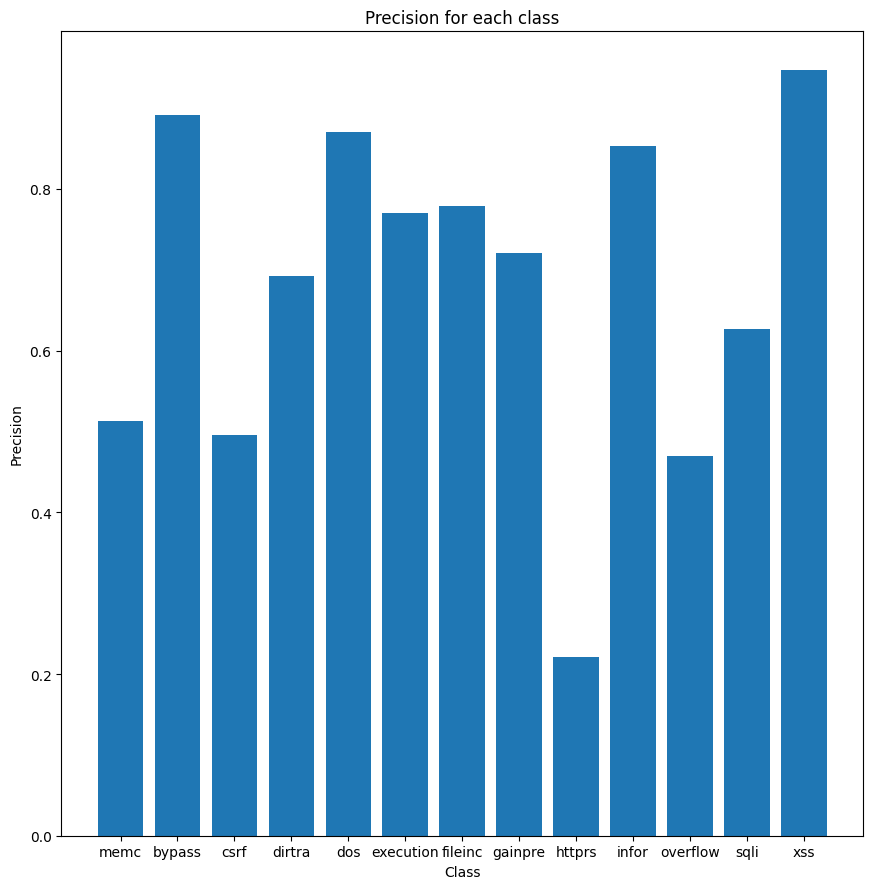

In [ ]:
classes = np.array(csv_labels)
plt.figure(figsize=(17, 9))
precision_per_class = precision_score(y_test, gnb_predictions, average=None)
for idx in range(13):
  print(f'precision of {csv_labels[idx]}: {precision_per_class[idx]:.4f}')


# Precision plot
plt.subplot(1, 2, 2)
plt.bar(classes, precision_per_class)
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for each class')
plt.xticks(classes)

plt.tight_layout()
plt.show()

recall of memc: 79.07%
recall of bypass: 96.38%
recall of csrf: 84.88%
recall of dirtra: 88.72%
recall of dos: 82.22%
recall of execution: 38.35%
recall of fileinc: 91.65%
recall of gainpre: 78.75%
recall of httprs: 92.42%
recall of infor: 76.52%
recall of overflow: 65.18%
recall of sqli: 92.14%
recall of xss: 81.95%


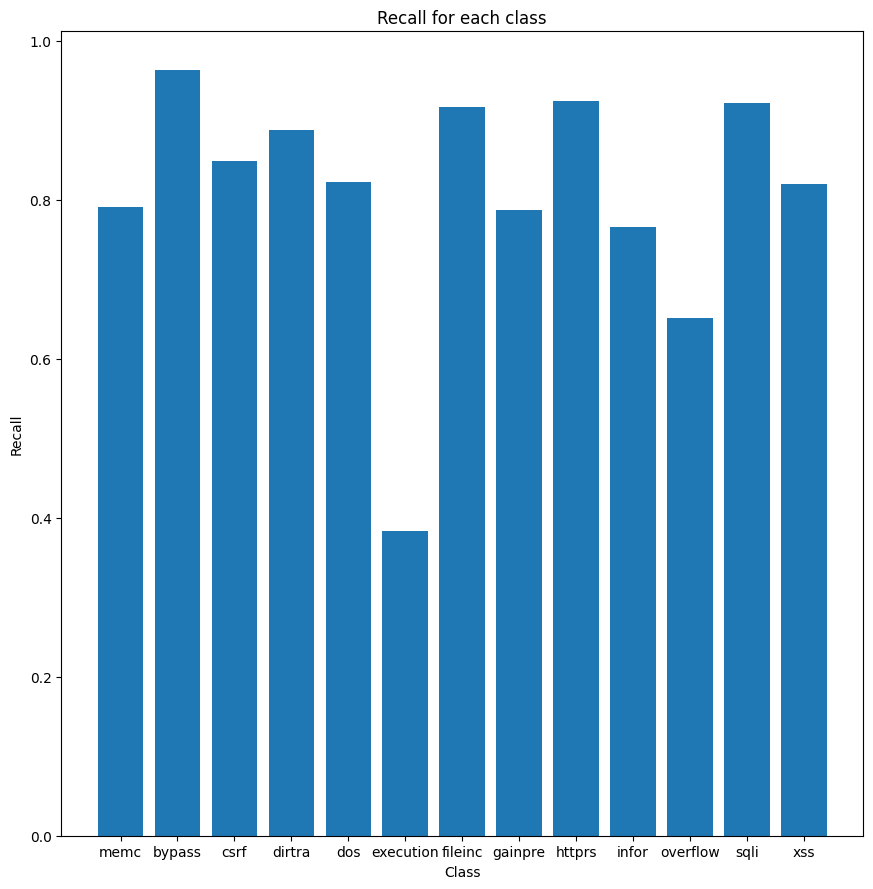

In [ ]:
plt.figure(figsize=(17, 9))
recall_per_class = recall_score(y_test, gnb_predictions, average=None)
for idx in range(13):
  formatted_recall = "{:.2f}%".format(recall_per_class[idx] * 100)
  print(f'recall of {csv_labels[idx]}: {formatted_recall}')


# Recall plot
plt.subplot(1, 2, 2)
plt.bar(classes, recall_per_class)
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for each class')
plt.xticks(classes)

plt.tight_layout()
plt.show()

F1-score of memc: 0.6223
F1-score of bypass: 0.9261
F1-score of csrf: 0.6260
F1-score of dirtra: 0.7777
F1-score of dos: 0.8453
F1-score of execution: 0.5121
F1-score of fileinc: 0.8419
F1-score of gainpre: 0.7524
F1-score of httprs: 0.3567
F1-score of infor: 0.8070
F1-score of overflow: 0.5458
F1-score of sqli: 0.7459
F1-score of xss: 0.8789


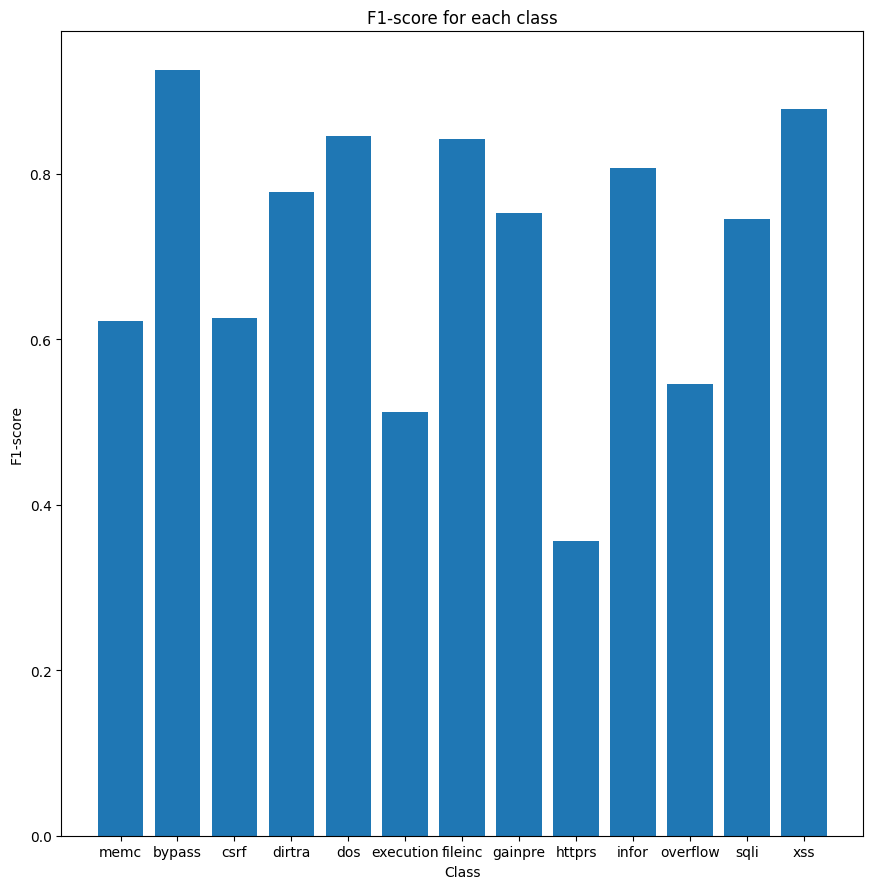

In [ ]:
plt.figure(figsize=(17, 9))
f1_per_class = f1_score(y_test, gnb_predictions, average=None)

for idx in range(13):
    print(f'F1-score of {csv_labels[idx]}: {f1_per_class[idx]:.4f}')

# F1-score plot
plt.subplot(1, 2, 2)
plt.bar(classes, f1_per_class)
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for each class')
plt.xticks(classes)

plt.tight_layout()
plt.show()

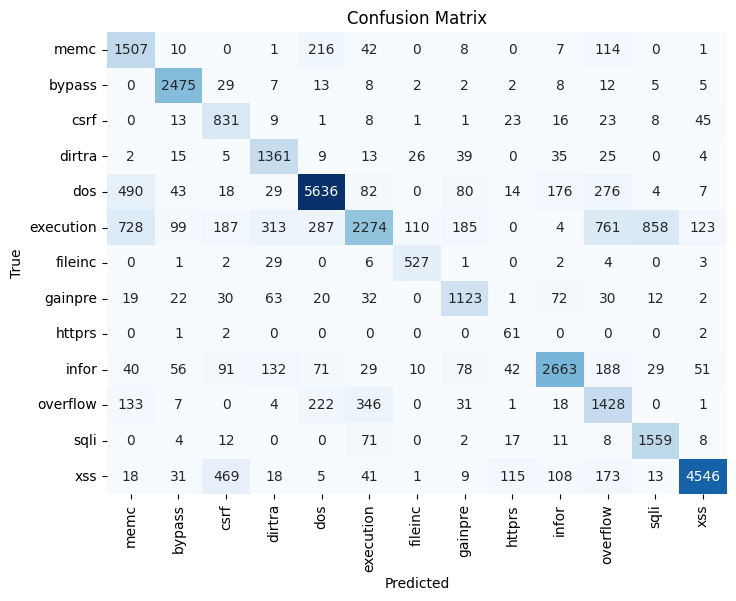

In [ ]:
# confusion matrix plot
cm = confusion_matrix(y_test, gnb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=csv_labels, yticklabels=csv_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()